In [1]:
#import cdsapi #<- API to resquest data
#Data from:
#https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download

In [2]:
import pandas as pd
import xarray as xr
import numpy as np

from cartopy import crs as ccrs, feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd

plt.style.use('fivethirtyeight')

In [3]:
ds_new = xr.open_dataset('data/era5_2022_2023.nc')
ds_new['ssrd'] = ds_new['ssrd']/3600
ds_new = ds_new.assign_coords(time=ds_new.valid_time - pd.Timedelta(hours=3))
ds_new

<xarray.Dataset> Size: 102MB
Dimensions:     (valid_time: 17520, latitude: 17, longitude: 17)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 140kB 2022-01-01 ... 2023-12-31T2...
  * latitude    (latitude) float64 136B -11.0 -11.25 -11.5 ... -14.75 -15.0
  * longitude   (longitude) float64 136B -45.0 -44.75 -44.5 ... -41.25 -41.0
    expver      (valid_time) <U4 280kB ...
    time        (valid_time) datetime64[ns] 140kB 2021-12-31T21:00:00 ... 202...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 20MB ...
    msl         (valid_time, latitude, longitude) float32 20MB ...
    sp          (valid_time, latitude, longitude) float32 20MB ...
    tp          (valid_time, latitude, longitude) float32 20MB ...
    ssrd        (valid_time, latitude, longitude) float32 20MB 0.0 0.0 ... 0.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-09-05T17:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
ds = xr.open_dataset('data/era5_2024.nc')
try:
    ds = ds.reduce(np.nansum, dim='expver',keep_attrs=True)
except:
    pass
ds['ssrd'] = ds['ssrd']/3600 #Data conversion
ds = ds.assign_coords(time=ds.time - pd.Timedelta(hours=3))
ds

<xarray.Dataset> Size: 68MB
Dimensions:    (longitude: 17, latitude: 17, time: 5856)
Coordinates:
  * longitude  (longitude) float32 68B -45.0 -44.75 -44.5 ... -41.5 -41.25 -41.0
  * latitude   (latitude) float32 68B -11.0 -11.25 -11.5 ... -14.5 -14.75 -15.0
  * time       (time) datetime64[ns] 47kB 2023-12-31T21:00:00 ... 2024-08-31T...
Data variables:
    t2m        (time, latitude, longitude) float64 14MB 297.5 296.3 ... 292.7
    msl        (time, latitude, longitude) float64 14MB 1.014e+05 ... 1.021e+05
    sp         (time, latitude, longitude) float64 14MB 9.507e+04 ... 9.317e+04
    ssrd       (time, latitude, longitude) float64 14MB -6.468e-14 ... -6.468...
    tp         (time, latitude, longitude) float64 14MB 1.438e-05 ... 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-06 01:26:24 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
#Check if all dims has the same lenght of non NaN values
len(ds.t2m.dropna(dim='time')) == len(ds.msl.dropna(dim='time')) == len(ds.sp.dropna(dim='time')) == len(ds.tp.dropna(dim='time')) == len(ds.ssrd.dropna(dim='time'))

True

In [6]:
lon, lat = -13.30021076, -43.32352929
df = ds.sel(latitude=lat, longitude=lon, method='nearest').to_pandas()
df = df.drop(columns=['latitude', 'longitude'])
rename_to = {
    't2m':'tmp',
    'msl': 'mslp',
    'ssrd': 'irradiance'
}
df = df.rename(columns=rename_to)
df['mslp'] = df['mslp']/100
df['sp'] = df['sp']/100
df['tmp'] = df['tmp']  - 273.16
df

,tmp,mslp,sp,irradiance,tp
time,,,,,
2023-12-31 21:00:00,25.019210,1013.357601,925.576296,-6.467518e-14,0.0
2023-12-31 22:00:00,24.646790,1014.505610,926.567647,-6.467518e-14,0.0
2023-12-31 23:00:00,24.129710,1014.961396,926.847647,-6.467518e-14,0.0
2024-01-01 00:00:00,23.558108,1014.553146,926.316404,-6.467518e-14,0.0
2024-01-01 01:00:00,22.589023,1014.417995,926.065161,-6.467518e-14,0.0
...,...,...,...,...,...
2024-08-31 16:00:00,26.738413,1018.504847,929.962455,4.572296e+02,0.0
2024-08-31 17:00:00,25.198166,1019.009412,930.306022,2.159711e+02,0.0
2024-08-31 18:00:00,22.638269,1019.593203,930.685914,2.521890e+01,0.0


In [7]:
lon, lat = -13.30021076, -43.32352929
df_new = ds_new.sel(latitude=lat, longitude=lon, method='nearest').to_pandas().reset_index().set_index('time')
df_new = df_new.drop(columns=['latitude', 'longitude', 'valid_time', 'expver', 'number'])
rename_to = {
    't2m':'tmp',
    'msl': 'mslp',
    'ssrd': 'irradiance'
}
df_new = df_new.rename(columns=rename_to)
df_new['mslp'] = df_new['mslp']/100
df_new['sp'] = df_new['sp']/100
df_new['tmp'] = df_new['tmp']  - 273.16
df_new

,tmp,mslp,sp,tp,irradiance
time,,,,,
2021-12-31 21:00:00,20.801300,1013.805603,925.680603,7.295609e-05,0.000000
2021-12-31 22:00:00,20.703522,1014.165649,925.921875,3.623962e-05,0.000000
2021-12-31 23:00:00,20.358673,1014.052490,925.726868,0.000000e+00,0.000000
2022-01-01 00:00:00,19.969879,1013.759399,925.351257,4.768372e-07,0.000000
2022-01-01 01:00:00,19.821686,1013.372498,924.892517,0.000000e+00,0.000000
...,...,...,...,...,...
2023-12-31 16:00:00,27.159821,1011.623779,924.216858,2.632141e-04,450.986664
2023-12-31 17:00:00,28.155914,1011.338135,923.776855,1.201630e-04,272.515564
2023-12-31 18:00:00,27.593658,1012.300598,924.633728,9.279251e-04,76.533333


In [8]:
df_concat = pd.concat([df_new, df],axis=0)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23376 entries, 2021-12-31 21:00:00 to 2024-08-31 20:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tmp         23376 non-null  float64
 1   mslp        23376 non-null  float64
 2   sp          23376 non-null  float64
 3   tp          23376 non-null  float64
 4   irradiance  23376 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB


<Axes: xlabel='time'>

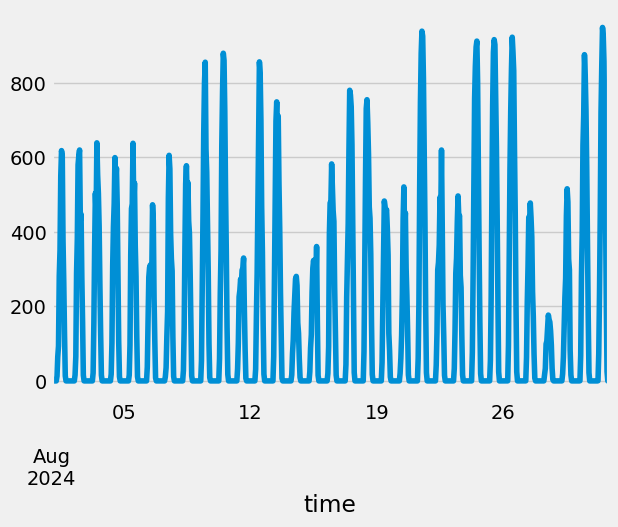

In [9]:
#Check data
df_concat[(df_concat.index >= '2024-07-01') & (df_concat.index >= '2024-08-01')].irradiance.plot()

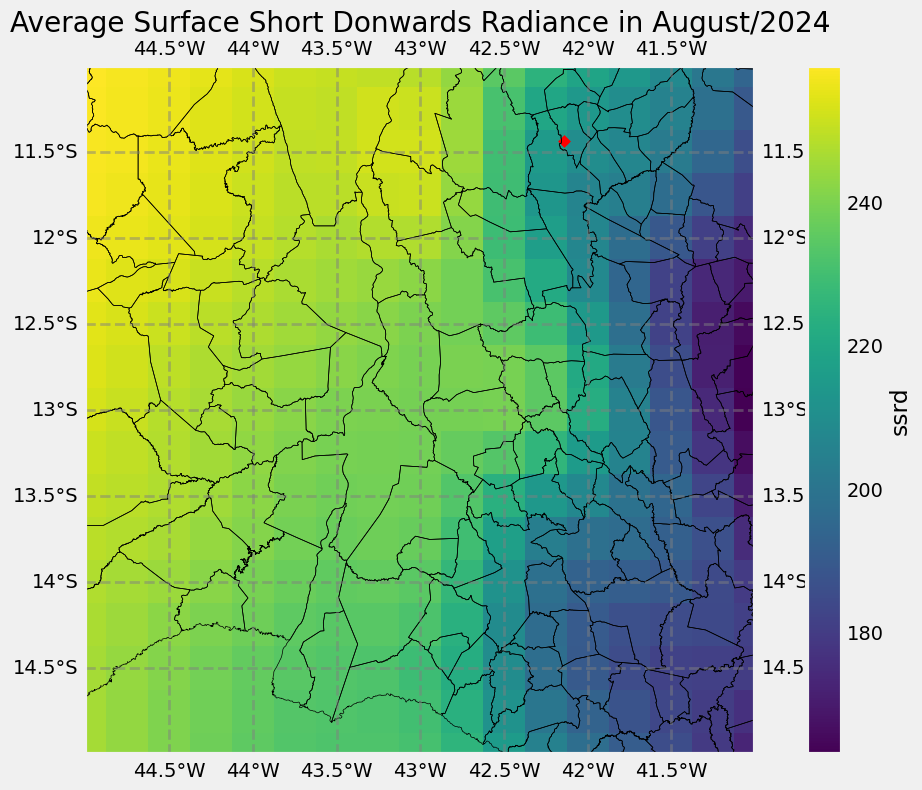

In [14]:
fig = plt.figure(figsize=(12, 8.5))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

shp=gpd.read_file("data/shapes_bahia/BA_Municipios_2022.shp")
ds.sel(time=slice('2024-08-01T20:00:00.000000000', '2024-08-31T20:00:00.000000000')).mean(dim='time').ssrd.plot()
shp.boundary.plot(ax=ax, color='k',linewidth=0.5)
ax.coastlines()
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([ds.longitude.min(), ds.longitude.max(), ds.latitude.min(), ds.latitude.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='k')
plt.title('Average Surface Short Donwards Radiance in August/2024')
plt.scatter(-42.138389, -11.437222, color='r', marker='D')
ttl = ax.title
ttl.set_position([.5, 1.05])

plt.savefig('imgs/era5_analysis/average_ssdr_august.jpg', bbox_inches='tight')


In [11]:
#df_concat.to_csv('data/era_data_ufv_bom_jesus.csv', sep=';')

In [12]:
df_ec = pd.read_csv('data/ec_forecast_ufv_bom_jesus.csv', sep=';', index_col=0)
df_ec.index = pd.to_datetime(df_ec.index)

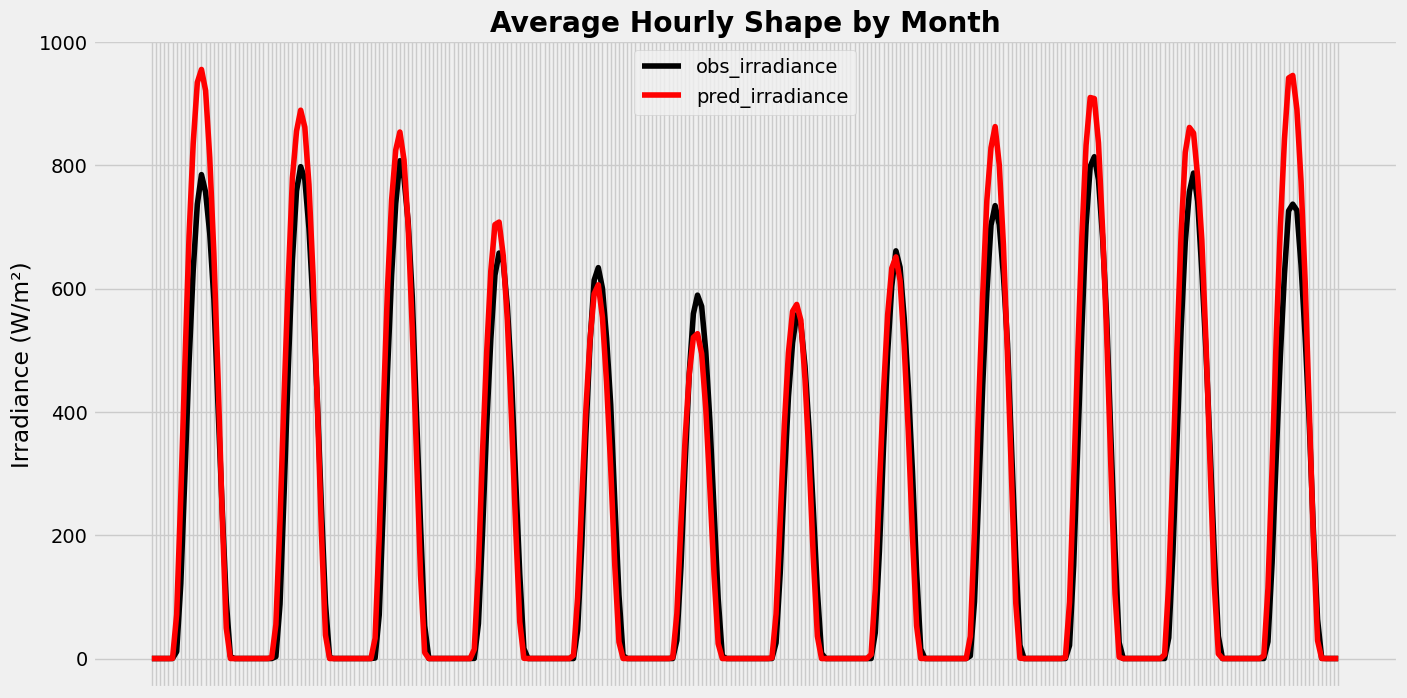

In [13]:
hourly_shape = df_concat[['irradiance']].copy()
hourly_shape['ec_irradiance'] = df_ec['irradiance']

df_m = hourly_shape[['irradiance', 'ec_irradiance']].copy()
df_m['MesHora'] = df_m.index.strftime('%m %H:%M')
df_m = df_m.groupby('MesHora').mean()


fig, ax = plt.subplots(figsize=(15,8))
ax.set_xticklabels([])

ax.plot(df_m['irradiance'], color='k', label='obs_irradiance')
ax.plot(df_m['ec_irradiance'], color='r', label='pred_irradiance')


ax.set_ylabel('Irradiance (W/m²)')


plt.legend()
plt.title('Average Hourly Shape by Month', weight='bold')
plt.savefig('imgs/era5_analysis/average_hourly_shape_era_vs_ec.jpg', bbox_inches='tight')

plt.show()